# Settings

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# System of Equations

### Settings

In [31]:
# Set seed
np.random.seed(0)
# Settings
nodes = 10
initial_concentrations = {i:j for i, j in zip(range(10), np.zeros(10))} # Random initial concentrations
decay_rate = 0.995
capacity = 1
k = 0.6
production = {5: 0.01, 9: 0}
t = 8

### Functions

In [3]:
def initialize_matrix(nodes, initial_concentrations, decay_rate, k, independent=False):
    """Goal:
        Initialize the matrices A, B, b, c and d for the diffusion problem.
    ------------------------------------------------------------------------------------
        Input:
            nodes: int
                The number of nodes in the system.
            initial_concentrations: dict
                The initial concentrations of the nodes.
            decay_rate: float
                The decay rate of the system.
            k: float
                The diffusion rate.
            independent: bool
                If True, the diffusion is only evaluated at t
    ------------------------------------------------------------------------------------
        Output:
            A: np.array
                The matrix A for t + dt.
            B: np.array
                The matrix B for t.
            b: np.array
                The production at t.
            c: np.array
                The concentrations at t.
            d: np.array
                The decay rates.
                """
    # Define the matrices
    A = np.zeros((nodes, nodes)) # A is for t + dt
    B = np.zeros((nodes, nodes)) # B is for t
    b = np.zeros((nodes, 1)) # b is production at t
    c = np.zeros((nodes, 1)) # c are the concentrations at t
    d = np.ones((nodes, 1)) * decay_rate # d are the decay rates

    # Set the initial concentrations
    for i in range(nodes):
        if i in initial_concentrations.keys():
            c[i] = initial_concentrations[i]
    
    # Set the production
    for i in range(nodes):
        if i in production.keys():
            b[i] = production[i]

    # ---- Fill matrices
    for i in range(nodes):
        # Set diagonals
        A[i, i] = capacity
        B[i, i] = capacity
        # Set connections with next node
        if independent == False:
            k_val = 0.5 * k
        else:
            k_val = 1 * k
        if i != (nodes - 1):
            A[i, i] += k_val
            A[i, i + 1] -= k_val
            B[i, i] -= k_val
            B[i, i + 1] += k_val
        # Set connections with previous node
        if i != 0:
            A[i, i] += k_val
            A[i, i - 1] -= k_val
            B[i, i] -= k_val
            B[i, i - 1] += k_val
    return A, B, b, c, d


def solve(A, B, b, c, d):
    """Goal:
        Solve the diffusion problem in parallel.
    ------------------------------------------------------------------------------------
        Input:
            A: np.array
                The matrix A for t + dt.
            B: np.array
                The matrix B for t.
            b: np.array
                The production at t.
            c: np.array
                The concentrations at t.
            d: np.array
                The decay rates.
    ------------------------------------------------------------------------------------
        Output:
            c: np.array
                The concentrations at t + dt.
                """
    v = np.dot(B, c)
    c = np.linalg.solve(A, d * (v + b))
    return c

def solve_seq(A, B, b, c, d):
    """Goal:
            Solve the diffusion problem sequentially.
        ------------------------------------------------------------------------------------
        Input:
            A: np.array
                The matrix A for t + dt.
            B: np.array
                The matrix B for t.
            b: np.array
                The production at t.
            c: np.array
                The concentrations at t.
            d: np.array
                The decay rates.
        ------------------------------------------------------------------------------------
        Output:
            c: np.array
                The concentrations at t + dt."""
    # Increase
    c += b
    # Diffusion
    v = np.dot(B, c)
    c = np.linalg.solve(A, v)
    # Decay
    c *= d
    return c

def solve_seqind(A, B, b, c, d):
    """Goal:
            Solve the diffusion problem sequentially, but evaluate only at t.
        ------------------------------------------------------------------------------------
        Input:
            A: np.array
                The matrix A for t + dt.
            B: np.array
                The matrix B for t.
            b: np.array
                The production at t.
            c: np.array
                The concentrations at t.
            d: np.array
                The decay rates.
        ------------------------------------------------------------------------------------
        Output:
            c: np.array
                The concentrations at t + dt."""
    # Increase
    c += b
    # Diffusion
    c = np.dot(B, c)
    # Decay
    c *= d
    return c / capacity

### Do an experiment

Initial: [0.]
Sequential, only evaluate at t: [0.07822084]
Parallel: [0.07822084]


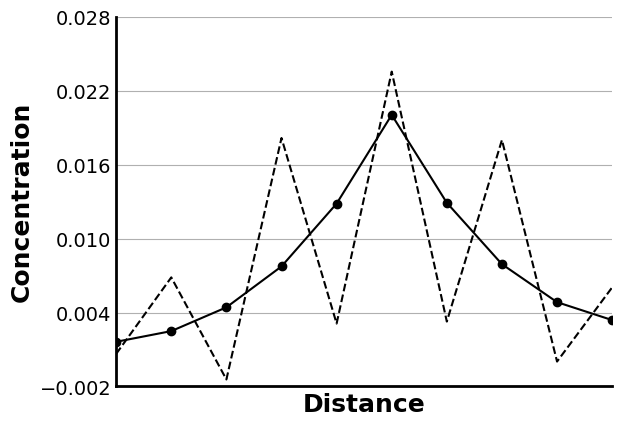

In [32]:
# ---- Solve sequential, only evaluate at t
# Initialize
A, B, b, c, d = initialize_matrix(nodes, initial_concentrations, decay_rate, k, independent=True)
print("Initial:", sum(c))
# Solve
for _ in range(t):
    c = solve_seqind(A, B, b, c, d)

print("Sequential, only evaluate at t:", sum(c))
plt.plot(c, linestyle='--', color = "k")

# # ---- Solve sequential, evaluate at t and t + dt
# # Initialize
# A, B, b, c, d = initialize_matrix(nodes, initial_concentrations, decay_rate, k)
# # Solve
# for _ in range(t):
#     c = solve_seq(A, B, b, c, d)

# print("Sequential, evaluate at t and t + dt:", sum(c))
# plt.plot(c, linestyle='--')

# ---- Solve parallel
# Initialize
A, B, b, c, d = initialize_matrix(nodes, initial_concentrations, decay_rate, k)
# Solve
for _ in range(t):
    c = solve(A, B, b, c, d)

print("Parallel:", sum(c))
plt.plot(c, marker = 'o', color = "k")

# --- Plot production as bar
#plt.bar(range(nodes), b.flatten(), color='grey', alpha=0.5)

# Set labels
plt.xlabel("Distance", fontsize=18, fontweight='bold')
plt.ylabel("Concentration", fontsize=18, fontweight='bold')

# Remove thicks and labels
plt.xticks([])
plt.yticks([])

## Set yticks
plt.yticks(np.arange(-2, 3, 0.6) / 100)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Wider axes line
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

# Remove tick indicators
plt.gca().xaxis.set_tick_params(which='both', size=0, labelsize = 14)
plt.gca().yaxis.set_tick_params(which='both', size=0, labelsize = 14)

# Set limits
plt.xlim(0, nodes - 1)
plt.ylim(-0.002, 0.028)

#plt.legend(["Sequential, only evaluate at t", "Sequential, evaluate at t and t + dt", "Parallel"])
#plt.legend(["Sequential & evaluated at t", "Parallel"], loc='upper left', fontsize=14, frameon=False)
plt.grid()
plt.show()

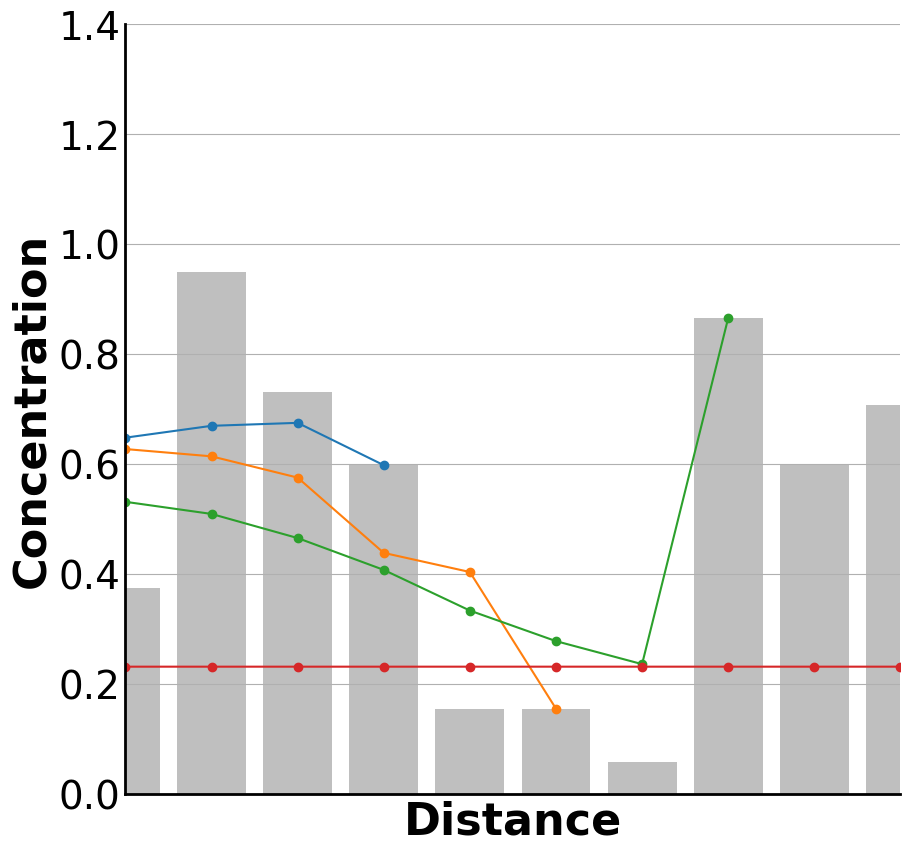

In [66]:
np.random.seed(42)

# Increase figure size
plt.figure(figsize=(10, 10))

# Settings
mode1 = "random initialization"
mode2 = "common production"

tnew = 100
nodes = 1
max_nodes = 10
threshold = 0.2
decay_rate = 0.975
k = 1

t2plot = [4, 6, 8]


if mode1 == "equal initialization" or mode1 == "equal production":
    initial_concentrations = {i:j for i, j in enumerate(np.ones(max_nodes) * threshold)}
    initial_concentrations[0] = 2 * threshold
elif mode1 == "random initialization" or mode1 == "random production":
    initial_concentrations = {i:j for i, j in enumerate(np.random.rand(max_nodes))}

if mode2 == "own production":
    production = {i:j / 100 for i, j in initial_concentrations.items()}
elif mode2 == "common production":
    production = {i: np.mean(list(initial_concentrations.values())) / 100 for i in range(max_nodes)}


if mode1 == "random production" or mode1 == "equal production":
    initial_concentrations = {i:j for i, j in enumerate(np.zeros(max_nodes))}
    initial_concentrations[0] = 2 * threshold
    production = {i:j*10 for i, j in production.items()} 
    initial_values = np.array(list(production.values()))
else:
    initial_values = np.array(list(initial_concentrations.values()))

c = np.array([initial_concentrations[0]])  


# Solve
for rep in range(tnew):
    # Initialize
    for icval, cval in enumerate(c):
        initial_concentrations[icval] = cval
    A, B, b, c, d = initialize_matrix(nodes, initial_concentrations, decay_rate, k)

    # ---
    if ((nodes in t2plot) and (plotnodes == True)):
        plt.plot(c, label = f"Placement of Cell {len(c)}", marker = 'o')
    elif (rep == (tnew - 1)):
        plt.plot(c, label = "Final Time Step", marker = 'o')

    # Solve
    c = solve(A, B, b, c, d)

    # Set new node?
    if (c[-1] > threshold) and (nodes < max_nodes):
        nodes += 1
        plotnodes = True
    else:
        plotnodes = False
        

# Plot initialization as bar
if mode1 == "random production" or mode1 == "equal production":
    plt.bar(range(max_nodes), initial_values * 10, color='grey', alpha=0.5)
else:
    plt.bar(range(max_nodes), initial_values, color='grey', alpha=0.5)

# Plot
plt.xlabel("Distance", fontsize=32, fontweight='bold')
plt.ylabel("Concentration", fontsize=32, fontweight='bold')
plt.xticks([])
plt.yticks(np.arange(0, 1.5, 0.2))

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Wider axes line
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

# Remove tick indicators
plt.gca().xaxis.set_tick_params(which='both', size=0, labelsize = 28)
plt.gca().yaxis.set_tick_params(which='both', size=0, labelsize = 28)

plt.xlim(0, max_nodes - 1)
plt.ylim(0, 1.4)
plt.grid()
#plt.legend(loc = "center right", fontsize = 8, frameon = False)
plt.show()

# Karine's GRN

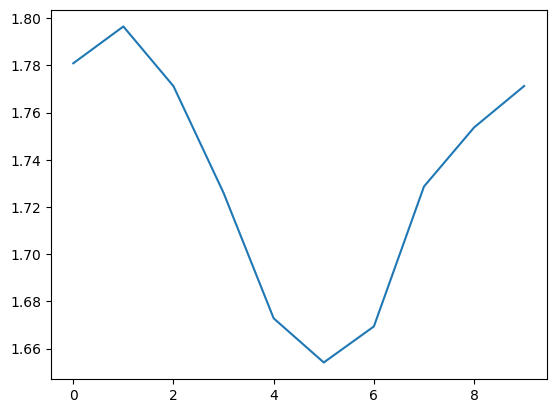

In [6]:
c = np.zeros((nodes, 1))
k = 0.005 / 8
decay_rate = 0.005
threshold = 0.5

# Set the initial concentrations
for i in initial_concentrations.keys():
    c[i] = initial_concentrations[i]

def diffuse(c, k, i):
    # Backwards
    if c[i] >= k:
        if i != 0:
            c[i - 1] += k
            c[i] -= k
    # Forwards
    if c[i] >= k:
        if i != (nodes - 1):
            c[i + 1] += k
            c[i] -= k
    return c

for _ in range(20):
    for i in range(nodes):
        # Diffusion
        c = diffuse(c, k, i)
        if c[i] >= decay_rate:
            c[i] -= decay_rate

plt.plot(c)
plt.show()

New Cell: 1.1507143064099161
New Cell: 1.3073510950163632
New Cell: 1.2523340317052183
New Cell: 0.7821856562950457
New Cell: 0.5470873484837255
New Cell: 0.3316272864100622
New Cell: 1.0319897889799663
New Cell: 1.117109906233192
New Cell: 1.2666275309126416


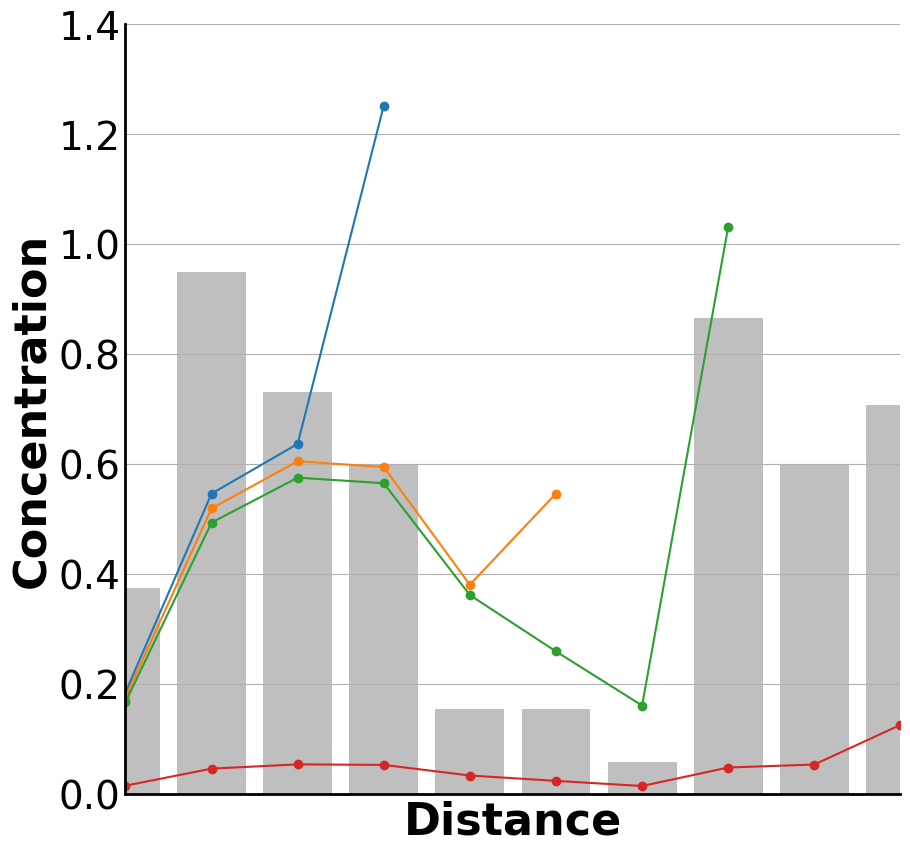

In [59]:
# Set random seed
np.random.seed(42)

mode1 = "random initialization"
mode2 = "common production"


# Increase figure size
plt.figure(figsize=(10, 10))

t = 100
toplot = [1, 4, 6, 8, 100]

threshold = 0.2
decay = 0.975

c = [threshold * 2]
max_nodes = 10
if mode1 == "equal initialization":
    initial_values = max_nodes * [threshold + 0.4]
elif mode1 == "random initialization":
    initial_values = np.random.rand(max_nodes)

if mode2 == "own production":
    production = np.array(initial_values) / 100
elif mode2 == "common production":
    production = np.mean(initial_values) / 100




for rep in range(t):
    new_cell = False
    for i in range(0, len(c)):
        # Production
        if mode2 == "own production":
            c[i] += production[i]
        elif mode2 == "random production":
            c[i] += production
        # Setting new cell
        if (i == (len(c) - 1)) and (c[i] > threshold) and ((len(c) + 1) <= max_nodes):
            # Share half of concentration
            c.append(0.5 * c[i])
            c[i] = 0.5 * c[i]
            # Initialize like expression does
            c[-1] += initial_values[i + 1]
            print(f"New Cell: {c[-1]}")
            new_cell = True
        # Decay
        c[i] *= decay
        
    if (len(c) in toplot) and (new_cell == True):
        plt.plot(c, marker = "o", label = f"Placement of Cell {len(c)}")
    elif rep == (t - 1):
        plt.plot(c, marker = "o", label = "Final Time step")


# Plot initialization as bar
plt.bar(range(max_nodes), initial_values, color='grey', alpha=0.5)

# Set limits
plt.xlim(0, max_nodes - 1)
plt.ylim(0, 1.4)

# Remove thicks and labels
plt.xticks([])
#plt.yticks([])

# Set yticks
plt.yticks(np.arange(0, 1.5, 0.2))

# Labels
plt.xlabel("Distance", fontsize=32, fontweight='bold')
plt.ylabel("Concentration", fontsize=32, fontweight='bold')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Wider axes line
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

# Remove tick indicators
plt.gca().xaxis.set_tick_params(which='both', size=0, labelsize = 28)
plt.gca().yaxis.set_tick_params(which='both', size=0, labelsize = 28)

#plt.legend(fontsize = 20, frameon = False, bbox_to_anchor=(0.5, 0.2))
plt.grid()
plt.show()


# Multiplicative vs. Subtractive Decay

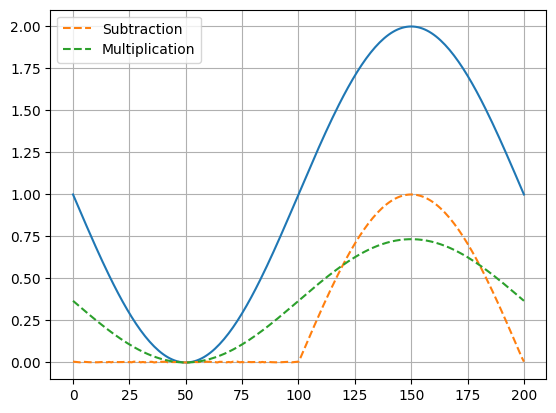

In [8]:
y = np.sin(np.linspace(-np.pi, np.pi, 201)) + 1

plt.plot(y)

for _ in range(200):
    for i in range(0, len(y)):
        if y[i] >= 0.005:
            y[i] -= 0.005

plt.plot(y, "--", label = "Subtraction")

y = np.sin(np.linspace(-np.pi, np.pi, 201)) + 1
for _ in range(200):
    y *= 0.995

plt.plot(y, "--", label = "Multiplication")
plt.grid()
plt.legend()
plt.show()

